In [1]:
import os
import pandas as pd
import numpy as np
import re
from sklearn.impute import KNNImputer
# These functions are needed to check dtypes and convert if necessary
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

In [2]:
# A dictionary of sheet description to better remember the purpose of each sheet.
sheets_desc = {"Data": "مشخصات پرسشنامه",
               "P1":"قسمت یکم: خصوصیات اجتماعی اعضای خانوار",
               "P2": "قسمت دوم: مشخصات محل سکونت",
               "P3S01": "قسمت سوم: بخش ۱ هزینه‌های خوراکی خانوار در ماه گذشته",
               "P3S02": "قسمت سوم: بخش ۲ هزینه‌های نوشیدنی‌های طبقه‌بندی نشده و دخانی های خانوار در ماه گذشته",
               "P3S03": "قسمت سوم: بخش ۳ هزینه‌های پوشاک و کفش خانوار در ماه گذشته",
               "P3S04": "قسمت سوم: بخش ۴ هزینه‌های بخش مسکن، آب، فاضلاب، سوخت و روشنایی خانوار در ماه گذشته",
               "P3S05": "قسمت سوم: بخش ۵ هزینه‌های مبلمان و لوازم خانگی",
               "P3S06": "قسمت سوم: بخش ۶ هزینه‌های بهداشتی و درمانی خانوار در ماه گذشته",
               "P3S07": "قسمت سوم: بخش ۷ هزینه‌های حمل و نقل خانوار در ماه گذشته",
               "P3S08": "قسمت سوم: بخش ۸ هزینه‌های ارتباطات خانوار در ماه گذشته",
               "P3S09": "قسمت سوم: بخش ۹ هزینه‌های خدمات فرهنگی و تفریحات خانوار در ماه گذشته",
               "P3S10": "قسمت سوم: بخش ۱۰ هزینه‌های آموزش و تحصیل",  # empty sheet, included in P3S13
               "P3S11": "قسمت سوم: بخش ۱۱ هزینه‌های غذاهای آماده، هتل و رستوران خانوار در ماه گذشته",
               "P3S12": "قسمت سوم: بخش ۱۲ هزینه‌های کالاها و خدمات متفرقه خانوار در ماه گذشته",
               "P3S13": "قسمت سوم: بخش ۱۳ سایر هزینه‌ها و انتقالات در ۱۲ ماه گذشته",
               "P3S14": "قسمت سوم: بخش ۱۴ سرمایه‌گذاری خانوار در ۱۲ ماه گذشته",
               "P4S01": "قسمت چهارم: بخش ۱ درآمد پولی اعضای شاغل خانوار از مشاغل مزد و حقوق بگیری",
               "P4S02": "قسمت چهارم: بخش ۲ درآمد پولی اعضای شاغل خانوار از مشاغل غیر مزد و حقوق بگیری (آزاد)",
               "P4S03": "قسمت چهارم: بخش ۳ درآمدهای متفرقه خانوار در ۱۲ ماه گذشته",
               "P4S04": "قسمت چهارم: ستون ۹ بخش ۳ شامل وام و یارانه"
               }

In [3]:
#Desired info:
sheet_indices = [0,1,2,9,13, 15, 17,18,19,20]

In [4]:
resource_directory = "G:\\ai\\project 1\\dataset"
resource_files : list[str] = []
for f in os.listdir(resource_directory):
    f_path = os.path.join(resource_directory, f)
    if os.path.isfile(f_path):
        resource_files.append(f)
del f, f_path

In [5]:
def empty_string_remover(df):
    for col in df.columns:
    # Checking if string dtype
        if is_string_dtype(df[col]):
            # replace cells with only empty strings with np.nan
            df[col] = df[col].replace(r'^\s*$', np.nan, regex=True)
    return df

In [6]:
dfs = []

for filename in resource_files:

    file_path = os.path.join(resource_directory, filename)
    year_file = pd.ExcelFile(file_path, engine='openpyxl')

    if filename.startswith("U"):
        Urban = True
    else:
        Urban = False

    year = int(filename.strip(".xlsx")[1:])
    if (year==99) or (year ==98):
        year = 1300+year

    for sheet_index in sheet_indices:

        sheet_name = list(sheets_desc.keys())[sheet_index]
        print(f"Sheet name from sheets_desc dict: {sheet_name}.",
            f"Sheet name from file: {year_file.sheet_names[sheet_index]}\n",
            f"Loaded sheet description: {sheets_desc[sheet_name]}")

        if sheet_index==0:
            current_df = pd.read_excel(year_file, year_file.sheet_names[sheet_index])
            current_df = empty_string_remover(current_df)
            # Here we add year and Urban columns to the Data (first sheet) dataframe
            current_df["Urban"] = Urban
            current_df["Year"] = year

            # Drop rows that:
                # TakmilDescA is not being nan, these only exist in year 1401.
                # TakmilDescB or JaygozinDescA or JaygozinDescB or JaygozinDescC is not nan,
                # Jaygozin ==2,
                # However, JaygozinDescC does not appear to have a specific definition.
                # Because all the above mean the end of survey for that family.

            current_df = current_df.loc[current_df.TakmilDescA.isna() |
                                    current_df.TakmilDescB.isna() |
                                    current_df.JaygozinDescA.isna() |
                                    current_df.JaygozinDescB.isna() |
                                    current_df.Jaygozin!=2, :]
            if "JaygozinDescC" in current_df.columns:
                current_df = current_df.loc[current_df.JaygozinDescC.isna(), :]

            # We only consider addresses from this dataframe and do left join with other dfs
            year_df = current_df.loc[:, ["Address", "Fasl", "Urban", "Year", "khanevartype", "province", "town"]].copy()
            del current_df

        if sheet_index==1:
            current_df = pd.read_excel(year_file, year_file.sheet_names[sheet_index])
            current_df = empty_string_remover(current_df)
            # Counting family members of each family
            family_member_count = (current_df.groupby("Address")
                                .agg({"member": "count"})
                                .rename(columns={"member": "member_cnt"}).reset_index())

            # Counting employed or student members of a family,
            # presumably because the go outside more and have more transportation expense
            active_member_count = (current_df.loc[current_df.occupationalst.str.lower().isin(["employed", "student"]),
                                                    ["Address", "occupationalst"]]
                                            .groupby("Address").agg({"occupationalst": "count"})
                                            .rename(columns={"occupationalst": "active_member_cnt"})
                                            .reset_index())
            family_mean_age = (current_df.groupby("Address").agg({"age": "mean"})
                                .rename(columns={"age": "mean_age"})
                                .reset_index())





            # Counting members with more than Diploma education
            # Maybe these people go out more often
            highly_educated_members_count = (current_df.loc[current_df.degree
                                                            .isin(['Bachelor', 'College', 'Master', 'PhD']),
                                                            ["Address", "degree"]]
                                            .groupby("Address").agg({"degree": "count"})
                                            .rename(columns={"degree": "highly_educated_member_cnt"})
                                            .reset_index())

            year_df = pd.merge(year_df, family_member_count, how="left", on="Address")
            year_df = pd.merge(year_df, active_member_count, how="left", on="Address")
            year_df = pd.merge(year_df, family_mean_age, how="left", on="Address")
            year_df = pd.merge(year_df, highly_educated_members_count, how="left", on="Address")
            del current_df, family_member_count, active_member_count, family_mean_age, highly_educated_members_count


        # Maybe if they have vehicles, they spend less on public transportation cost
        # However, they might spend more on personal vehicle expenses
        if sheet_index==2:
            cols = ["Address","tenure", "vehicle", "motorcycle", "bicycle"]
            current_df = pd.read_excel(year_file, year_file.sheet_names[sheet_index], usecols = cols)
            current_df = empty_string_remover(current_df)
            year_df = pd.merge(year_df, current_df, how="left", on="Address")
            del current_df

        # Transportation expenses
        if sheet_index==9:
            current_df = pd.read_excel(year_file, year_file.sheet_names[sheet_index])
            current_df = empty_string_remover(current_df)
            transportation_cost_df = (current_df.groupby("Address").agg({"value": "sum"})
                                .rename(columns={"value": "transportation_cost"})
                                .reset_index())
            year_df = pd.merge(year_df, transportation_cost_df, how="left", on="Address")
            del current_df, transportation_cost_df

        # Dining out more, might require more transportation costs for families
        if sheet_index==13:
            current_df = pd.read_excel(year_file, year_file.sheet_names[sheet_index])
            current_df = empty_string_remover(current_df)
            current_df = (current_df.groupby("Address").agg({"value": "sum"})
                                .rename(columns={"value": "dining_expenses"})
                                .reset_index())
            year_df = pd.merge(year_df, current_df, how="left", on="Address")
            del current_df

        # بخش 13 اطلاعات مفیدی در رابطه با حمل و نقل داره مانند بیمه مرتبط با حمل و نقل یا هزینه های مربوط به خرید وسایل نقلیه
        if sheet_index==15:
            current_df = pd.read_excel(year_file, year_file.sheet_names[sheet_index])
            # current_df = empty_string_remover(current_df)
            current_df.value = pd.to_numeric(current_df.value, errors='coerce')
            current_df.value = current_df.value.fillna(0).astype("int64")
            # مخارج حق بیمه مرتبط با حمل و نقل خانوار
            transport_insurance_df = (current_df.loc[current_df.code.isin([125411,125412,125413]), :]
                                .groupby("Address").agg({"value":"sum"}).rename(columns={"value": "Insurance_expenses"})
                                .reset_index())
            # هزینه های مربوط به خرید وسایل نقلیه و تجهیزات مربوطه
            vehicle_expenses_df = (current_df.loc[current_df.code.astype("str").str.match("^7[12]\d+$")]
                            .groupby("Address").agg({"value":"sum"}).rename(columns={"value": "Vehicle_purchase_expenses"})
                            .reset_index())
            year_df = pd.merge(year_df, transport_insurance_df, how="left", on="Address")
            year_df = pd.merge(year_df, vehicle_expenses_df, how="left", on="Address")
            del current_df, transport_insurance_df, vehicle_expenses_df

        if sheet_index==17:
            income_wage_df = pd.read_excel(year_file, year_file.sheet_names[sheet_index])
            income_wage_df = (empty_string_remover(income_wage_df).groupby("Address")
                                .agg({"netincome_w_y": "sum"})
                                .reset_index())
            year_df = pd.merge(year_df, income_wage_df, how="left", on="Address")
            del income_wage_df

        if sheet_index==18:
            #Calculating azad income
            income_azad_df = pd.read_excel(year_file, year_file.sheet_names[sheet_index])
            income_azad_df = empty_string_remover(income_azad_df).groupby("Address").agg({"income_s_y": "sum"}).reset_index()
            year_df = pd.merge(year_df, income_azad_df, how="left", on="Address")
            del income_azad_df

        if sheet_index==19:
            # Calculating miscellaneous income
            income_misc_df = pd.read_excel(year_file, year_file.sheet_names[sheet_index])
            for col in ["income_pension", "income_rent", "income_interest", "income_aid", "income_resale", "income_transfer"]:
                income_misc_df[col] = pd.to_numeric(income_misc_df[col], errors='coerce')
            income_misc_df = empty_string_remover(income_misc_df).fillna(0).astype("int64")
            income_misc_df = income_misc_df.groupby("Address").agg({"income_pension": "sum",
                                                        "income_rent": "sum",
                                                        "income_interest": "sum",
                                                        "income_aid": "sum",
                                                        "income_resale": "sum",
                                                        "income_transfer": "sum",
                                                        }).sum(axis=1).to_frame(name='misc_income').reset_index()
            year_df = pd.merge(year_df, income_misc_df, how="left", on="Address")
            del income_misc_df

        if sheet_index==20:
            #Calculatin subsidy income
            income_subsidy_df = pd.read_excel(year_file, year_file.sheet_names[sheet_index])
            income_subsidy_df = empty_string_remover(income_subsidy_df).fillna(0).astype("int64")
            income_subsidy_df = income_subsidy_df.groupby("Address").agg({"subsidy":"sum"}).reset_index()
            year_df = pd.merge(year_df, income_subsidy_df, how="left", on="Address")
            del income_subsidy_df

    dfs.append(year_df)

Sheet name from sheets_desc dict: Data. Sheet name from file: R1400Data
 Loaded sheet description: مشخصات پرسشنامه
Sheet name from sheets_desc dict: P1. Sheet name from file: R1400P1
 Loaded sheet description: قسمت یکم: خصوصیات اجتماعی اعضای خانوار
Sheet name from sheets_desc dict: P2. Sheet name from file: R1400P2
 Loaded sheet description: قسمت دوم: مشخصات محل سکونت
Sheet name from sheets_desc dict: P3S07. Sheet name from file: R1400P3S07
 Loaded sheet description: قسمت سوم: بخش ۷ هزینه‌های حمل و نقل خانوار در ماه گذشته
Sheet name from sheets_desc dict: P3S11. Sheet name from file: R1400P3S11
 Loaded sheet description: قسمت سوم: بخش ۱۱ هزینه‌های غذاهای آماده، هتل و رستوران خانوار در ماه گذشته
Sheet name from sheets_desc dict: P3S13. Sheet name from file: R1400P3S13
 Loaded sheet description: قسمت سوم: بخش ۱۳ سایر هزینه‌ها و انتقالات در ۱۲ ماه گذشته
Sheet name from sheets_desc dict: P4S01. Sheet name from file: R1400P4S01
 Loaded sheet description: قسمت چهارم: بخش ۱ درآمد پولی اعضای ش

In [7]:
final_df = pd.concat(dfs, axis=0)

In [8]:
final_df.to_pickle("prediction_features_df.pkl")

In [9]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 151824 entries, 0 to 19305
Data columns (total 23 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Address                     151824 non-null  int64  
 1   Fasl                        151824 non-null  int64  
 2   Urban                       151824 non-null  bool   
 3   Year                        151824 non-null  int64  
 4   khanevartype                151824 non-null  int64  
 5   province                    151824 non-null  object 
 6   town                        151824 non-null  int64  
 7   member_cnt                  151824 non-null  int64  
 8   active_member_cnt           118166 non-null  float64
 9   mean_age                    151824 non-null  float64
 10  highly_educated_member_cnt  43075 non-null   float64
 11  tenure                      151820 non-null  object 
 12  vehicle                     151824 non-null  bool   
 13  motorcycle          

In [10]:
final_df.head(5)

,Address,Fasl,Urban,Year,khanevartype,province,town,member_cnt,active_member_cnt,mean_age,...,motorcycle,bicycle,transportation_cost,dining_expenses,Insurance_expenses,Vehicle_purchase_expenses,netincome_w_y,income_s_y,misc_income,subsidy
0,20001383919,2,False,1400,1,Markazi,1,5,2.0,20.8,...,True,False,600000.0,NaN,NaN,488400000.0,354000000.0,NaN,158600000.0,23100000.0
1,20001383923,2,False,1400,1,Markazi,1,4,3.0,32.5,...,True,False,2800000.0,NaN,NaN,13600000.0,NaN,636000000.0,NaN,NaN
2,20001383925,2,False,1400,1,Markazi,1,4,1.0,46.5,...,True,False,2350000.0,NaN,NaN,5600000.0,NaN,173000000.0,42320000.0,17640000.0
3,20001383929,2,False,1400,1,Markazi,1,2,1.0,28.0,...,False,False,3000000.0,NaN,NaN,NaN,160000000.0,NaN,23560000.0,6720000.0
4,20001383932,2,False,1400,1,Markazi,1,2,NaN,61.5,...,False,False,2500000.0,NaN,NaN,NaN,NaN,NaN,416360000.0,10920000.0


In [11]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
encoder_province = encoder.fit_transform(final_df[['province']]).toarray()
encoder_province_df = pd.DataFrame(encoder_province, columns=encoder.get_feature_names_out(['province']))
final_df = final_df.drop(columns='province').reset_index(drop=True)
final_df = pd.concat([final_df, encoder_province_df], axis=1)

In [12]:
encoder_tenure = encoder.fit_transform(final_df[['tenure']]).toarray()
encoder_tenure_df = pd.DataFrame(encoder_tenure, columns=encoder.get_feature_names_out(['tenure']))
final_df = final_df.drop(columns='tenure').reset_index(drop=True)
final_df = pd.concat([final_df, encoder_tenure_df], axis=1)

In [13]:
final_df.dropna(subset=["transportation_cost"], inplace=True)

In [14]:
final_df['income_s_y'] = pd.to_numeric(final_df['income_s_y'], errors='coerce')

In [15]:
mean_netincome = final_df['netincome_w_y'].mean()
final_df['netincome_w_y'].fillna(mean_netincome, inplace=True)

mean_income = final_df['income_s_y'].mean()
final_df['income_s_y'].fillna(mean_income, inplace=True)

mean_misc = final_df['misc_income'].mean()
final_df['misc_income'].fillna(mean_misc, inplace=True)

mean_subsidy = final_df['subsidy'].mean()
final_df['subsidy'].fillna(mean_subsidy, inplace=True)

In [16]:
final_df.Insurance_expenses.fillna(0, inplace=True)
final_df.Vehicle_purchase_expenses.fillna(0, inplace=True)

In [17]:
final_df["total_income"] = final_df.netincome_w_y + final_df.income_s_y + final_df.subsidy + final_df.misc_income
final_df = final_df.drop(columns=["netincome_w_y", "income_s_y", "subsidy", "misc_income"])

In [18]:
final_df.drop(columns=['town', 'mean_age', 'dining_expenses', 'khanevartype', 'highly_educated_member_cnt', 'member_cnt', 'active_member_cnt'], inplace=True)

In [19]:
for col in final_df.columns:
    if final_df[col].dtype == bool:
        final_df[col] = final_df[col].astype(int)

In [20]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 137600 entries, 0 to 151823
Data columns (total 50 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Address                         137600 non-null  int64  
 1   Fasl                            137600 non-null  int64  
 2   Urban                           137600 non-null  int32  
 3   Year                            137600 non-null  int64  
 4   vehicle                         137600 non-null  int32  
 5   motorcycle                      137600 non-null  int32  
 6   bicycle                         137600 non-null  int32  
 7   transportation_cost             137600 non-null  float64
 8   Insurance_expenses              137600 non-null  float64
 9   Vehicle_purchase_expenses       137600 non-null  float64
 10  province_Alborz                 137600 non-null  float64
 11  province_Ardebil                137600 non-null  float64
 12  province_AzarbaijanGh

array([[<Axes: title={'center': 'Address'}>,
        <Axes: title={'center': 'Fasl'}>,
        <Axes: title={'center': 'Urban'}>,
        <Axes: title={'center': 'Year'}>,
        <Axes: title={'center': 'vehicle'}>,
        <Axes: title={'center': 'motorcycle'}>,
        <Axes: title={'center': 'bicycle'}>],
       [<Axes: title={'center': 'transportation_cost'}>,
        <Axes: title={'center': 'Insurance_expenses'}>,
        <Axes: title={'center': 'Vehicle_purchase_expenses'}>,
        <Axes: title={'center': 'province_Alborz'}>,
        <Axes: title={'center': 'province_Ardebil'}>,
        <Axes: title={'center': 'province_AzarbaijanGharbi'}>,
        <Axes: title={'center': 'province_AzarbaijanSharghi'}>],
       [<Axes: title={'center': 'province_Boushehr'}>,
        <Axes: title={'center': 'province_CharmahalBakhtiari'}>,
        <Axes: title={'center': 'province_Esfahan'}>,
        <Axes: title={'center': 'province_Fars'}>,
        <Axes: title={'center': 'province_Gilan'}>,
 

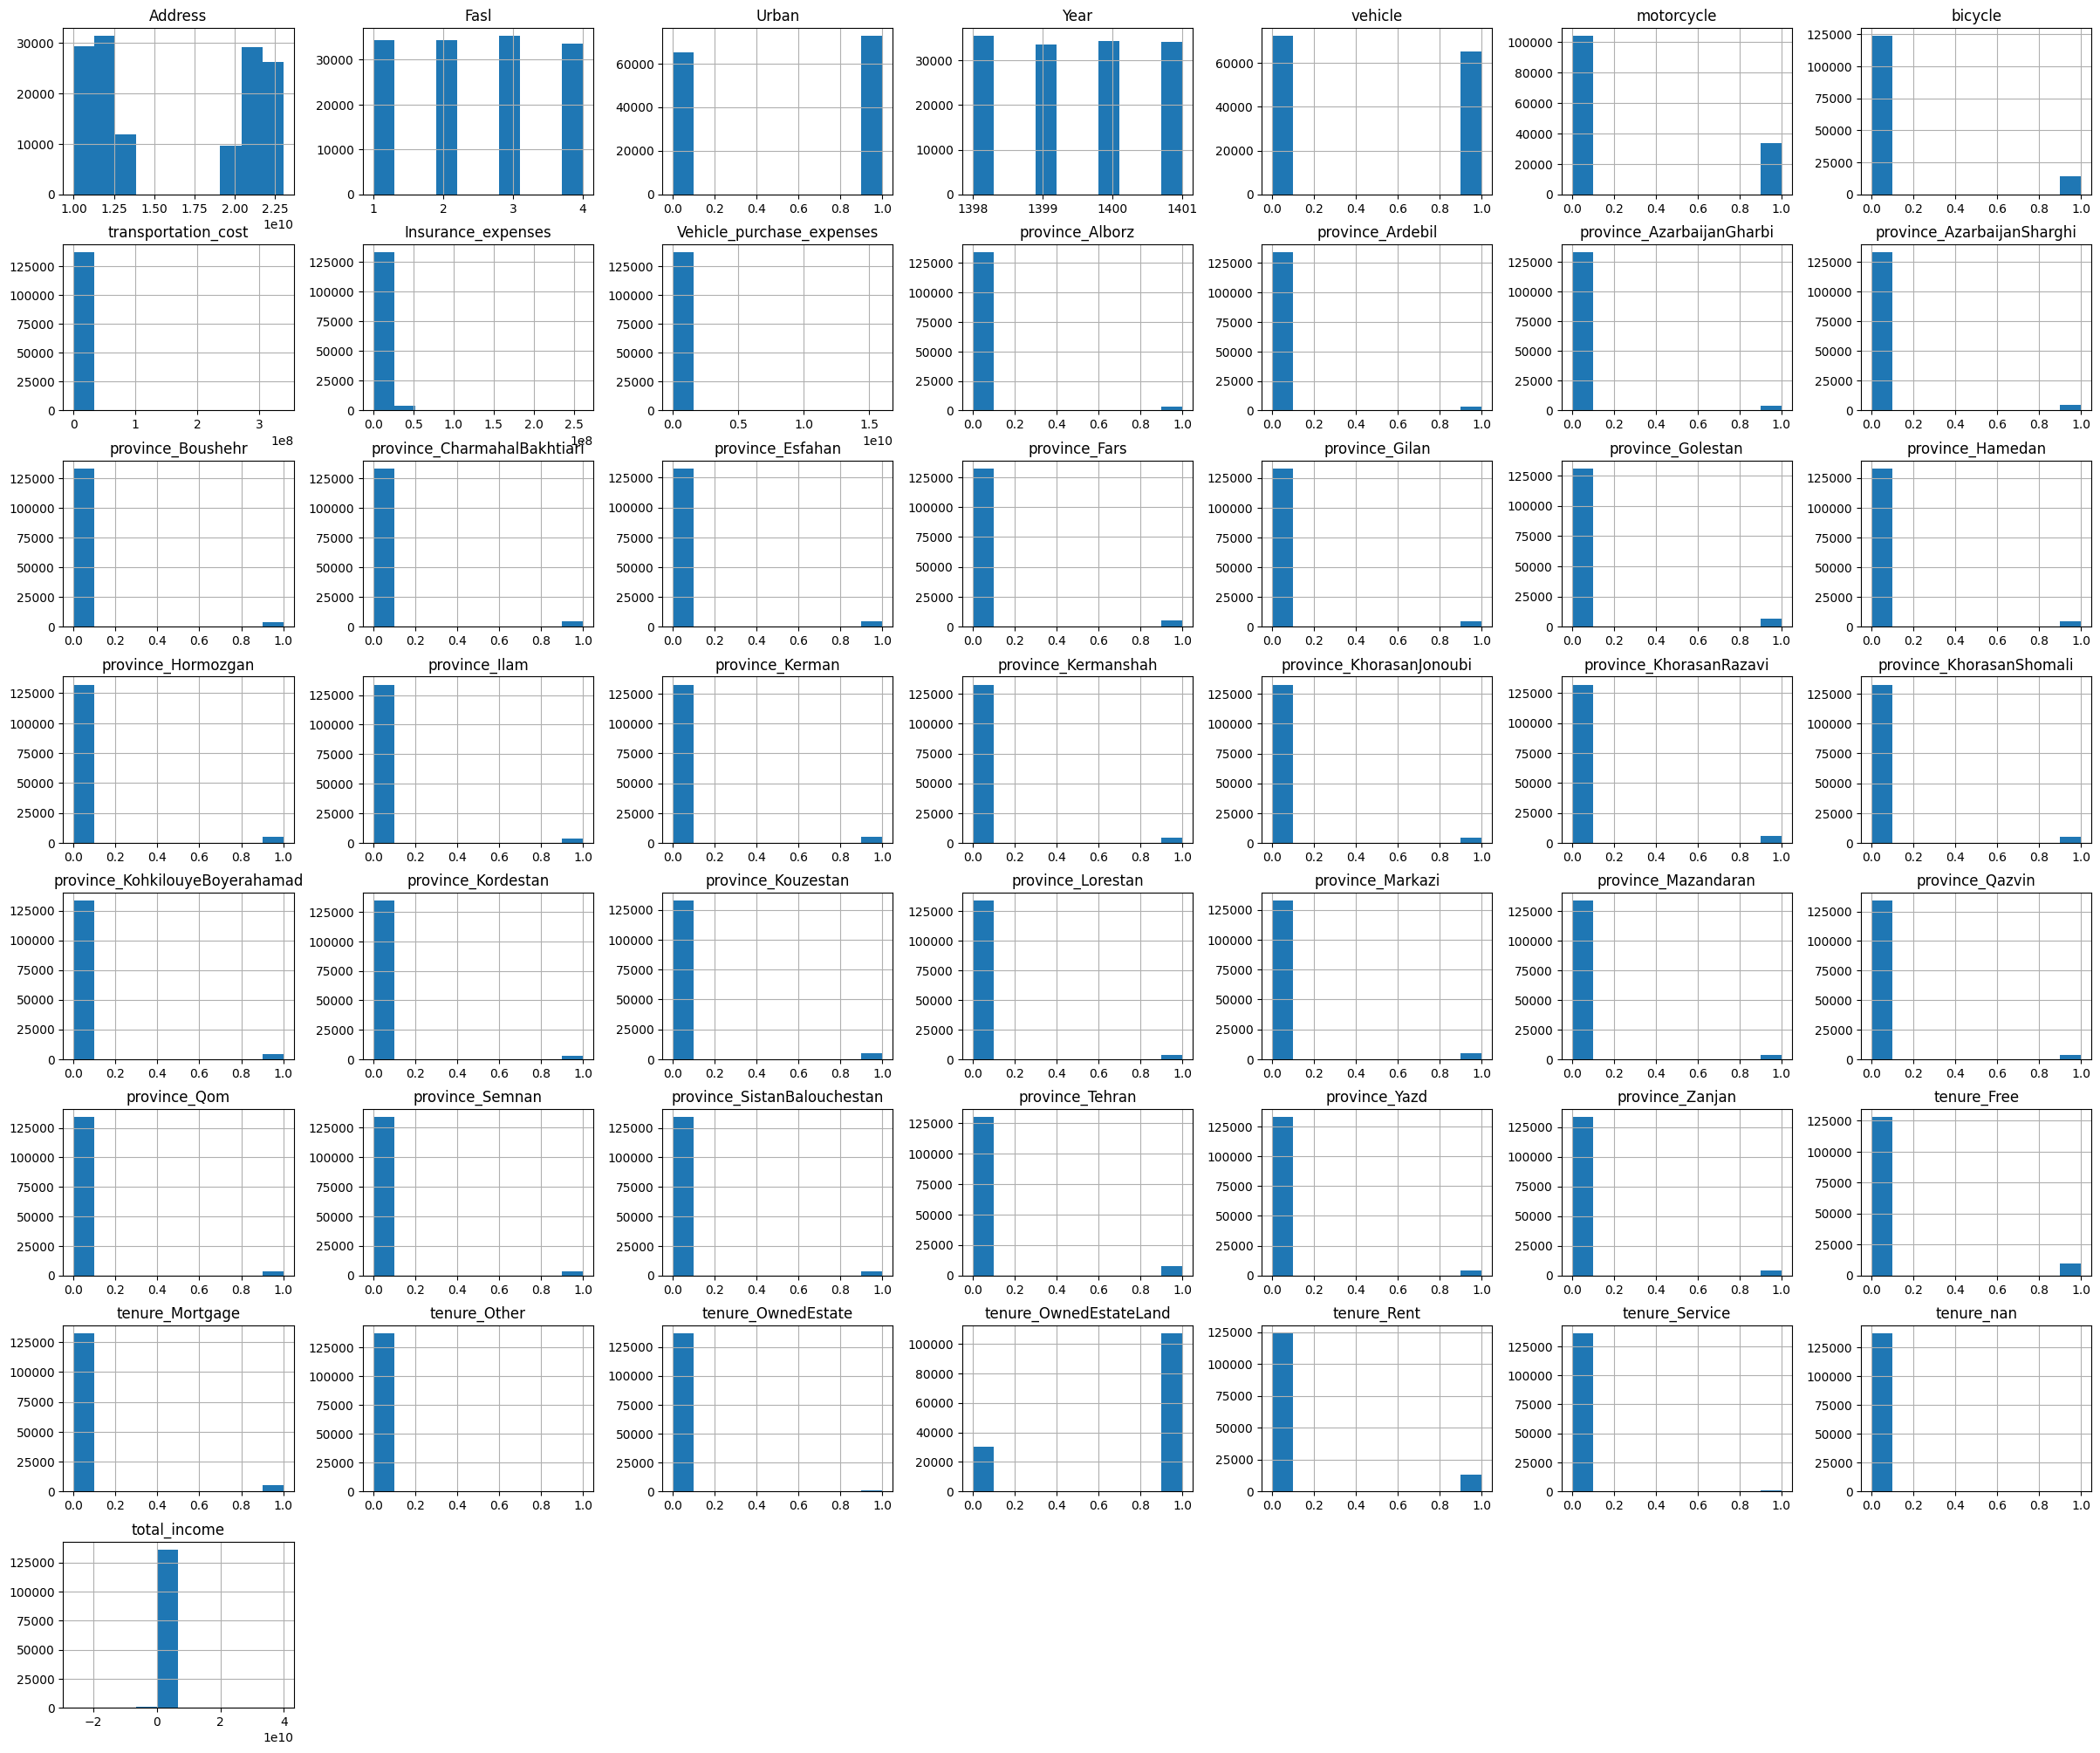

In [23]:
final_df.hist(figsize=(30, 25))

In [24]:
from sklearn.ensemble import IsolationForest
columns_outlier = ['Insurance_expenses', 'Vehicle_purchase_expenses', 'total_income']
iso_forest = IsolationForest(contamination=0.1, random_state=42)
final_df['outlier']=iso_forest.fit_predict(final_df[columns_outlier])
# np.unique(final_df['outlier'], return_counts=True)

# Filter out the outliers
df_clean = final_df[final_df['outlier'] == 1]

# Drop the outlier column as it's no longer needed
df_clean = df_clean.drop(columns=['outlier'])

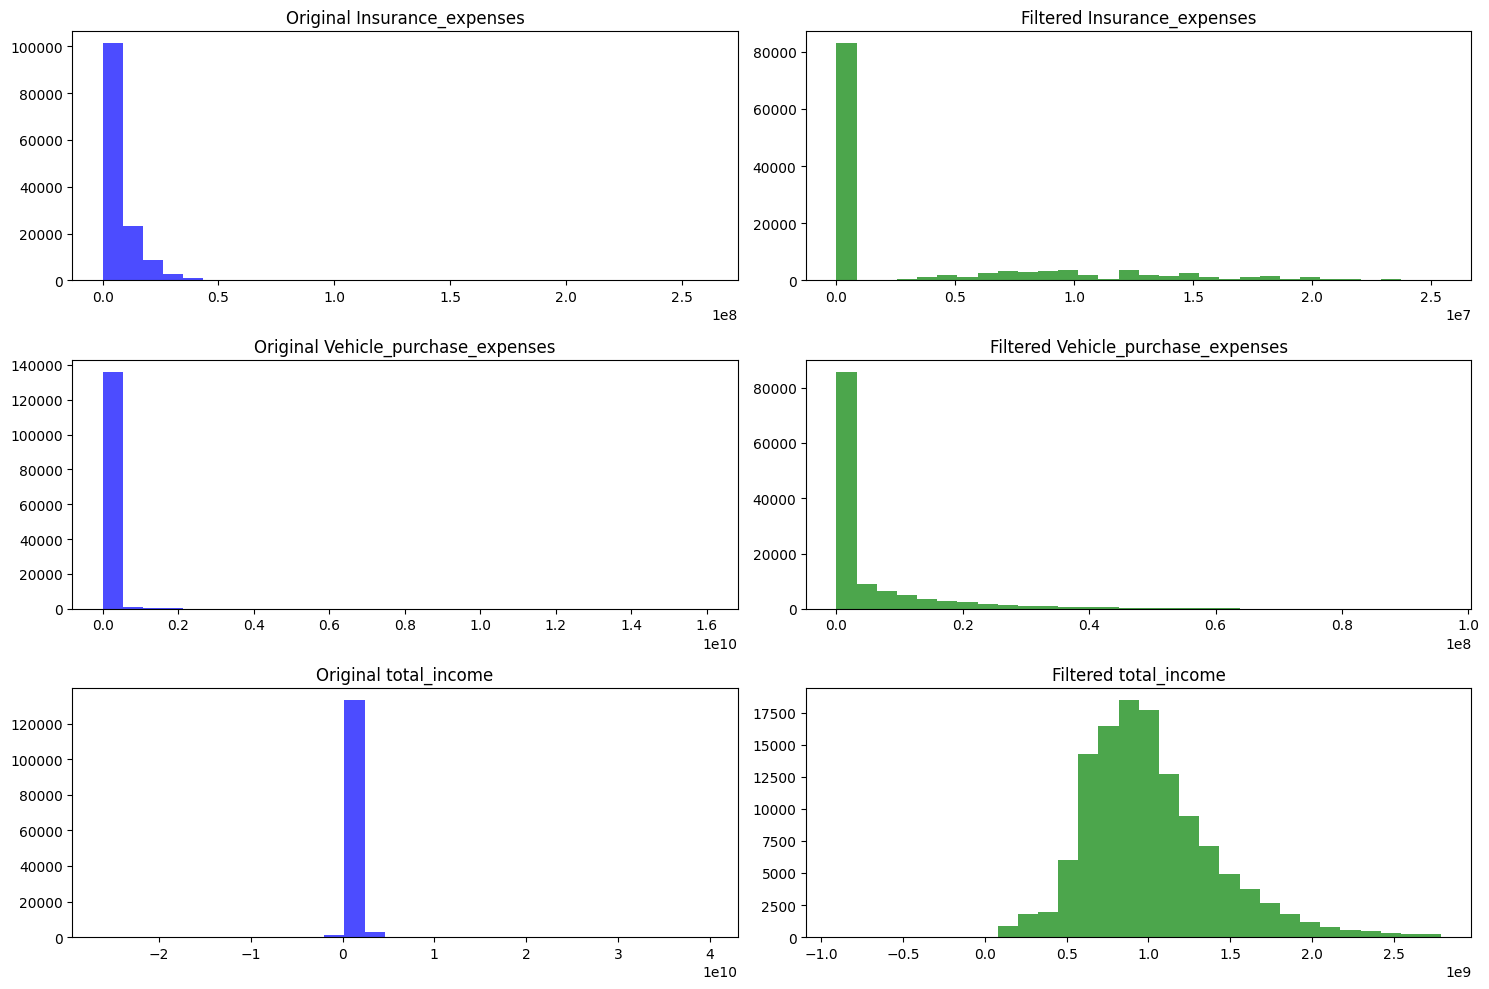

In [25]:
import matplotlib.pyplot as plt
# Plot histograms of the columns before and after removing outliers
fig, axs = plt.subplots(3, 2, figsize=(15, 10))

# Original data
for i, column in enumerate(columns_outlier):
    axs[i, 0].hist(final_df[column], bins=30, color='blue', alpha=0.7)
    axs[i, 0].set_title(f'Original {column}')

    # Filtered data
    axs[i, 1].hist(df_clean[column], bins=30, color='green', alpha=0.7)
    axs[i, 1].set_title(f'Filtered {column}')

plt.tight_layout()
plt.show()

In [26]:
winter_of_1401 = (df_clean['Year'] == 1401) & (df_clean['Fasl'] == 4)
X_test = df_clean[winter_of_1401]
X_train = df_clean[~winter_of_1401]

y_test = X_test.pop("transportation_cost")
y_train = X_train.pop("transportation_cost")

In [27]:
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()
columns_standard = ['Insurance_expenses', 'Vehicle_purchase_expenses', 'total_income']

# Extract the columns to be standardized from the training and test sets
X_train_to_standardize = X_train_copy[columns_standard]
X_test_to_standardize = X_test_copy[columns_standard]

In [28]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_to_standardize)
X_test_scaled = scaler.transform(X_test_to_standardize)

# Convert the scaled data back to DataFrames
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=columns_standard)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=columns_standard)

# Replace the original columns with the standardized columns in the training and test sets
X_train_copy[columns_standard] = X_train_scaled_df
X_test_copy[columns_standard] = X_test_scaled_df


In [29]:
X_train_copy.head()

,Address,Fasl,Urban,Year,vehicle,motorcycle,bicycle,Insurance_expenses,Vehicle_purchase_expenses,province_Alborz,...,province_Zanjan,tenure_Free,tenure_Mortgage,tenure_Other,tenure_OwnedEstate,tenure_OwnedEstateLand,tenure_Rent,tenure_Service,tenure_nan,total_income
1,20001383923,2,0,1400,0,1,0,-0.638439,0.028764,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.781272
2,20001383925,2,0,1400,0,1,0,-0.638439,-0.506371,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.010688
3,20001383929,2,0,1400,0,0,0,-0.638439,-0.506371,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.815272
4,20001383932,2,0,1400,0,0,0,-0.638439,-0.506371,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.695786
5,20001383935,2,0,1400,0,0,1,1.523083,1.944735,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.316261


In [30]:
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [31]:
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_copy)
X_test_imputed = imputer.transform(X_test_copy)
column_names = X_train_copy.columns
X_train_imputed = pd.DataFrame(X_train_imputed, columns=column_names)
X_test_imputed = pd.DataFrame(X_test_imputed, columns=column_names)

In [32]:
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

In [33]:
# Calculate VIF for the training set
vif_values = calculate_vif(X_train_imputed)
print("VIF values:")
print(vif_values)

VIF values:
                           Feature           VIF
0                          Address  1.122684e+06
1                             Fasl  1.020750e+00
2                            Urban  1.104890e+06
3                             Year  1.024233e+00
4                          vehicle  1.103497e+00
5                       motorcycle  1.162271e+00
6                          bicycle  1.045331e+00
7               Insurance_expenses  1.381304e+00
8        Vehicle_purchase_expenses  1.371496e+00
9                  province_Alborz  9.019827e+11
10                province_Ardebil  1.880417e+13
11       province_AzarbaijanGharbi  1.060294e+12
12      province_AzarbaijanSharghi  2.835127e+12
13               province_Boushehr  4.112876e+13
14     province_CharmahalBakhtiari  8.594656e+12
15                province_Esfahan  6.098307e+12
16                   province_Fars  6.928615e+14
17                  province_Gilan  2.859428e+13
18               province_Golestan  4.740631e+14
19      

In [35]:
for index, row in vif_values.iterrows():
    feature = row['Feature']
    vif = row['VIF']
    
    if vif <= 5:
        interpretation = "Acceptable"
    elif 5 < vif < 10:
        interpretation = "Moderate multicollinearity"
    else:
        interpretation = "High multicollinearity"
        
    print(f"Feature: {feature}, VIF: {vif}, Interpretation: {interpretation}")

Feature: Address, VIF: 1122683.997477143, Interpretation: High multicollinearity
Feature: Fasl, VIF: 1.0207502317450337, Interpretation: Acceptable
Feature: Urban, VIF: 1104890.1460128766, Interpretation: High multicollinearity
Feature: Year, VIF: 1.0242334272505604, Interpretation: Acceptable
Feature: vehicle, VIF: 1.1034965006012265, Interpretation: Acceptable
Feature: motorcycle, VIF: 1.162270506353744, Interpretation: Acceptable
Feature: bicycle, VIF: 1.0453310909526188, Interpretation: Acceptable
Feature: Insurance_expenses, VIF: 1.3813039349456637, Interpretation: Acceptable
Feature: Vehicle_purchase_expenses, VIF: 1.3714961312209983, Interpretation: Acceptable
Feature: province_Alborz, VIF: 901982701255.8574, Interpretation: High multicollinearity
Feature: province_Ardebil, VIF: 18804173809480.15, Interpretation: High multicollinearity
Feature: province_AzarbaijanGharbi, VIF: 1060294203030.1344, Interpretation: High multicollinearity
Feature: province_AzarbaijanSharghi, VIF: 283

In [37]:
def remove_high_vif_features(X, threshold=10):
    while True:
        vif_data = calculate_vif(X)
        print("VIF values:")
        print(vif_data)
        
        max_vif = vif_data["VIF"].max()
        if max_vif < threshold:
            break
        
        max_vif_feature = vif_data.loc[vif_data["VIF"] == max_vif, "Feature"].values[0]
        print(f"Removing feature with high VIF: {max_vif_feature}")
        
        # Drop the feature with the highest VIF value
        X = X.drop(columns=[max_vif_feature])
    
    return X

# Remove features with high VIF
df_cleaned = remove_high_vif_features(final_df)
print("Features remaining after removing high VIF:")
print(df_cleaned.columns)

# Calculate VIF for the cleaned dataset
vif_values_cleaned = calculate_vif(df_cleaned)
print("Final VIF values:")
print(vif_values_cleaned)

VIF values:
                           Feature           VIF
0                          Address  1.121050e+06
1                             Fasl  1.020734e+00
2                            Urban  1.104411e+06
3                             Year  1.222565e+00
4                          vehicle  1.872106e+00
5                       motorcycle  1.169227e+00
6                          bicycle  1.049748e+00
7              transportation_cost  1.218717e+00
8               Insurance_expenses  2.146803e+00
9        Vehicle_purchase_expenses  1.157158e+00
10                 province_Alborz  1.404763e+11
11                province_Ardebil  5.670040e+10
12       province_AzarbaijanGharbi  3.311336e+10
13      province_AzarbaijanSharghi  3.268215e+11
14               province_Boushehr  3.965658e+11
15     province_CharmahalBakhtiari  2.571553e+10
16                province_Esfahan  5.662021e+10
17                   province_Fars  7.612575e+11
18                  province_Gilan  1.175947e+10
19      

In [38]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 137600 entries, 0 to 151823
Data columns (total 51 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Address                         137600 non-null  int64  
 1   Fasl                            137600 non-null  int64  
 2   Urban                           137600 non-null  int32  
 3   Year                            137600 non-null  int64  
 4   vehicle                         137600 non-null  int32  
 5   motorcycle                      137600 non-null  int32  
 6   bicycle                         137600 non-null  int32  
 7   transportation_cost             137600 non-null  float64
 8   Insurance_expenses              137600 non-null  float64
 9   Vehicle_purchase_expenses       137600 non-null  float64
 10  province_Alborz                 137600 non-null  float64
 11  province_Ardebil                137600 non-null  float64
 12  province_AzarbaijanGh

In [39]:
def train_ridge_model(X_train, y_train, alpha):
    ridge_reg = Ridge(alpha=alpha)
    ridge_reg.fit(X_train, y_train)
    return ridge_reg

In [40]:
ridge_model = train_ridge_model(X_train_imputed, y_train, alpha=0.1)

# Evaluate the model on the test set
y_pred = ridge_model.predict(X_test_imputed)
mse = mean_squared_error(y_test, y_pred)
print(f"\nMean squared error on test set: {mse:.2f}")
r2 = r2_score(y_test, y_pred)
print(f"\nr2_score error on test set: {r2:.2f}")


Mean squared error on test set: 23097700422714.96

r2_score error on test set: 0.08


c:\Users\sazgar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=3.07292e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [42]:
model = RandomForestRegressor(n_estimators=200, random_state=42)
# model.fit(X_train_imputed, y_train)
param_grid = {'max_depth': [5, 10, 15], 'n_estimators': [50, 100, 200]}
grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_imputed, y_train)
best_params = grid_search.best_estimator_
print("best params: ", best_params)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
best params:  RandomForestRegressor(max_depth=5, n_estimators=200, random_state=42)


In [43]:
cv_scores = cross_val_score(best_params, X_train_imputed, y_train, cv = 5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

Cross-validation scores: [-0.01572686  0.20392837  0.10797625  0.18932252  0.14609144]
Mean cross-validation score: 0.12631834376436077


In [44]:
y_train_pred = best_params.predict(X_train_imputed)
y_test_pred = best_params.predict(X_test_imputed)

In [45]:
# Evaluate the model
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train MSE: {train_mse}")
print(f"Test MSE: {test_mse}")
print(f"Train R2: {train_r2}")
print(f"Test R2: {test_r2}")

Train MSE: 5535679427745.329
Test MSE: 22853643910669.2
Train R2: 0.21896512521714018
Test R2: 0.08591444814102123
